In [ ]:
# for dataframe
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import itertools

import os
from random import seed
from pathlib import Path

!pip install nltk                                                
from nltk.corpus import wordnet
import nltk

# tokenization
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# get bad symbols
from string import punctuation

# lemmatization
!pip install pymorphy2
import pymorphy2

# regex
import re

import gensim.downloader as api

# custom type
from typing import List, Tuple, Dict

#std lib with containers
from collections import defaultdict
from collections import Counter
from itertools import chain

# dl lib
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence
from torch.nn.functional import sigmoid, relu, elu, tanh
from torch.nn import Module, Embedding, LSTM, RNN, GRU, Linear, Sequential, Dropout
from torch.nn.utils.rnn import PackedSequence

# split dataset
from sklearn.model_selection import train_test_split

# tf-idf features
from sklearn.feature_extraction.text import TfidfVectorizer

# log reg
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# grad boosting
!pip install catboost 
from catboost import CatBoostClassifier

# optim params
from sklearn.model_selection import GridSearchCV

In [2]:
try:
    STOPWORDS = nltk.corpus.stopwords.words('russian')      
except:
    nltk.download('stopwords')
    STOPWORDS = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_excel("/content/drive/MyDrive/data_style_text_predict/data.xlsx")

In [4]:
df = df.drop(["Unnamed: 0"], axis=1)
df

,text,id
0,Генетики исследовали ДНК 700 малагасийцев и вы...,0
1,Но примерно тысячу лет назад они смешались с ...,0
2,Он сопровождался вымиранием местной мегафауны,0
3,"Об этом сообщается в статье, опубликованной в...",0
4,Основное население Мадагаскара составляют мал...,0
...,...,...
2495,"помнится знакомый, работал в вневедомственной ...",3
2496,А про саму зп ничего нет),3
2497,Донат в игре косметический и гриндится за внут...,3
2498,Перевод: - Где мне достать такого же? ------ Л...,3


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def text_preproccesing(df: pd.DataFrame) -> pd.DataFrame:

    df['text'] = df['text'].apply(lambda x : x.split(' '))
    
    df['text'] = df['text'].map(lambda x: [token.lower() for token in x if token != ' '\
                                                                  and token.strip() not in punctuation])

    df['text'] = df['text'].map(lambda x : ' '.join([word for word in x]))

    bad_symbols = punctuation + "«'»•—²�®❗️012345679"

    def remove_bad_symbols(text):
        return text.translate(str.maketrans(bad_symbols, ' ' * len(bad_symbols)))

    # удаление пунктуации, цифр и других неестественных символов
    df['text'] = df['text'].map(lambda x: remove_bad_symbols(x))

    # лемматизация 
    lemmatizer =  pymorphy2.MorphAnalyzer()
    df['text']  = df['text'].apply(lambda x: [lemmatizer.parse(word)[0].normal_form for word in str(x).split()])

    df['text'] = df['text'].apply(lambda x : ' '.join(x))

    df['id'] = df['id'].apply(lambda x : int(x))

    return df

In [7]:
df_preproccesing = text_preproccesing(df)
df_preproccesing

,text,id
0,генетика исследовать днк малагасиец и выяснить...,0
1,но примерно тысяча год назад они смешаться с в...,0
2,он сопровождаться вымирание местный мегафауна,0
3,о это сообщаться в статья опубликовать в журна...,0
4,основный население мадагаскар составлять малаг...,0
...,...,...
2495,помнится знакомый работать в вневедомственный ...,3
2496,а про сам зп ничего нет,3
2497,донат в игра косметический и гриндиться за вну...,3
2498,перевод где я достать такой же легально они уж...,3


### Classical ML подход

In [8]:
tfidf_features = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df=1,
    analyzer='word',
    max_features=50_000,
    smooth_idf=False,
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df_preproccesing.text.values,
    df_preproccesing.id.values,
    test_size=0.1,
    random_state=31,
)

In [10]:
# create tf-idf feature

X_train = tfidf_features.fit_transform(X_train)
X_test = tfidf_features.transform(X_test)

In [11]:
log_reg = LogisticRegression(
    max_iter=2000,
    solver='liblinear',
    penalty='l2',
    C=1000,
)

log_reg.fit(X_train, y_train)

LogisticRegression(C=1000, max_iter=2000, solver='liblinear')

In [12]:
y_pred = log_reg.predict(X_test)

F1_score = f1_score(
    y_pred,
    y_test,
    average="micro",
)

conf_mat = confusion_matrix(y_test, y_pred)

print(f'F1: {F1_score}')

F1: 0.908


Confusion matrix, without normalization
[[55  1  1  0  0]
 [ 1 43  1  0  0]
 [ 0  0 39  0  3]
 [ 1  0  3 48  7]
 [ 2  0  0  3 42]]


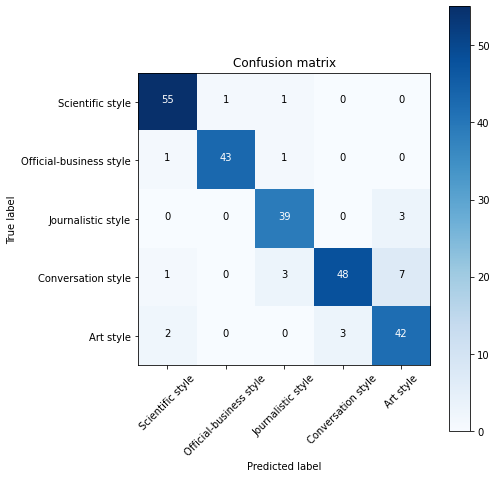

In [13]:

plot_confusion_matrix(conf_mat, [
    "Scientific style", 
    "Official-business style",
    "Journalistic style",
    "Conversation style", 
    "Art style"])

### DL подход

In [14]:
class Vocab:
    def __init__(self, tokenized_texts: List[List[str]], max_vocab_size: int = None) -> None:
        """
        Создает словарь путем объединения всех токенизированных текстов и подсчета слов.
        Самые частые слова помещаются в словарь, остальные заменяются токеном [UNK].
        :param tokenized_texts: текст для построения словаря
        :param max_vocab_size: количество слов в словаре
        """
        counts = Counter(chain(*tokenized_texts))

        # сколько слов учитываем
        max_vocab_size = max_vocab_size or len(counts)

        # каждому токену ставится в соответствиее число - сколько раз встретился в тексте
        common_pairs = counts.most_common(max_vocab_size)

        # падинг
        self.PAD_IDX = 0

        # неизвестный токен
        self.UNK_IDX = 1

        # конец предложения
        self.EOS_IDX = 2

        self.itos = ["<PAD>", "<UNK>", "<EOS>"] + [pair[0] for pair in common_pairs]

        # соответствие token -> idx
        self.stoi = {
            token: i for i, token in enumerate(self.itos)
        }

    def vectorize(self, text: List[str]) -> List[int]:
        """
        Сопоставляет каждому токену индекс в словаре
        :param text: последовательность токенов
        """
        return [
            self.stoi.get(tok, self.UNK_IDX) for tok in text
        ]

    def __iter__(self):
        return iter(self.itos)

    def __len__(self) -> int:
        return len(self.itos)

In [15]:
class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels: int, vocab: Vocab) -> None:

        self.texts = tokenized_texts
        self.labels = labels
        self.vocab = vocab

    def __getitem__(self, item) -> Tuple[List, int]:
        return self.vocab.vectorize(self.texts[item]) + [self.vocab.EOS_IDX], self.labels[item]

    def __len__(self) -> int:
        return len(self.texts)
    
    def collate_fn(self, batch):
        # чтобы не делать честный паддинг (дорого при вычислениях), делаем pack
        return pack_sequence([torch.tensor(pair[0]) for pair in batch], enforce_sorted=False), torch.tensor(
            [pair[1] for pair in batch])


In [16]:
def prepare_emb_matrix(gensim_model, vocab: Vocab):

    mean = gensim_model.vectors.mean(1).mean()
    std = gensim_model.vectors.std(1).mean()
    vec_size = gensim_model.vector_size
    emb_matrix = torch.zeros((len(vocab), vec_size))
    for i, word in enumerate(vocab.itos[1:], 1):
        try:
            emb_matrix[i] = torch.tensor(gensim_model.get_vector(word))
        except KeyError:
            emb_matrix[i] = torch.randn(vec_size) * std + mean
    return emb_matrix

In [24]:
class RecurrentClassifier(Module):
    def __init__(self, vocab: Vocab, emb_matrix):

        super().__init__()
        self.vocab = vocab
        self.emb_matrix = emb_matrix
        self.embeddings = Embedding.from_pretrained(emb_matrix, freeze=True,
                                                    padding_idx=vocab.PAD_IDX)

        self.cell = GRU(input_size=emb_matrix.size(1),
                               batch_first=True,
                               hidden_size=16,
                               num_layers=1,
                               dropout=0.05,
                               bidirectional=True,
                               )

        self.out_activation = relu
        self.out_dropout = Dropout(0.05)

        cur_out_size = 32

        out_layers = []

        for cur_hidden_size in [8]:
            out_layers.append(Linear(cur_out_size, cur_hidden_size))
            cur_out_size = cur_hidden_size

        out_layers.append(Linear(cur_out_size, 5))

        self.out_proj = Sequential(*out_layers)

    def forward(self, input):
        embedded = self.embeddings(input.data)
        _, last_state = self.cell(PackedSequence(embedded,
                                                 input.batch_sizes,
                                                 sorted_indices=input.sorted_indices,
                                                 unsorted_indices=input.unsorted_indices))
        if isinstance(last_state, tuple):
            last_state = last_state[0]
        last_state = last_state.transpose(0, 1)
        last_state = last_state.reshape(last_state.size(0), -1)
        return self.out_proj(last_state)

In [33]:
from typing import Dict

import torch
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.notebook import tqdm


class Trainer:
    def __init__(self, config: Dict):

        self.config = config
        self.n_epochs = config["n_epochs"]
        self.setup_opt_fn = lambda model: Adam(model.parameters(),
                                               config["lr"],
                                               weight_decay=config["weight_decay"])
        self.lr = config["lr"]
        self.model = None
        self.opt = None
        self.history = None
        self.loss_fn = CrossEntropyLoss()
        self.device = config["device"]
        self.verbose = True

    def fit(self, model, train_loader, val_loader):

        self.model = model.to(self.device)
        self.opt = self.setup_opt_fn(self.model)
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}
        for epoch in range(self.n_epochs):
            train_info = self._train_epoch(train_loader)
            val_info = self._val_epoch(val_loader)
            self.history["train_loss"].extend(train_info["train_loss"])
            self.history["val_loss"].append(val_info["loss"])
            self.history["val_acc"].append(val_info["acc"])
        return self.model.eval()

    def _train_epoch(self, train_loader):
        self.model.train()
        losses = []
        if self.verbose:
            train_loader = tqdm(train_loader)
        for batch in train_loader:
            self.model.zero_grad()
            texts, labels = batch
            logits = self.model.forward(texts.to(self.device))
            loss = self.loss_fn(logits, labels.to(self.device))
            loss.backward()
            self.opt.step()
            loss_val = loss.item()
            if self.verbose:
                train_loader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        return {"train_loss": losses}

    def _val_epoch(self, val_loader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_loader = tqdm(val_loader)
        with torch.no_grad():
            for batch in val_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                all_logits.append(logits)
                all_labels.append(labels)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits)
        loss = CrossEntropyLoss()(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        if self.verbose:
            print(f"Loss={loss:.3}; Acc:{acc:.3}")
            val_loader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
            
        self.save(f'./{int(acc * 1000)}.ckpt')
        return {"acc": acc, "loss": loss}

    def predict(self, test_loader):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                predictions.extend(logits.argmax(1).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
                      "trainer_config": self.config,
                      "vocab": self.model.vocab,
                      "emb_matrix": self.model.emb_matrix,
                      "state_dict": self.model.state_dict(),
                      }
        torch.save(checkpoint, path)

    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "vocab", "emb_matrix", "state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = RecurrentClassifier(ckpt["config"], ckpt["vocab"], ckpt["emb_matrix"])
        new_model.load_state_dict(ckpt["state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer


In [26]:
tok_texts = [
   word_tokenize(t, language="russian") for t in df_preproccesing.text.values
]

vocab = Vocab(tok_texts, max_vocab_size=25_000)

In [27]:
# store embeddings in current directory
os.environ["GENSIM_DATA_DIR"] = str(Path.cwd())
# will download embeddings or load them from disk
gensim_model = api.load("word2vec-ruscorpora-300")
emb_matrix = prepare_emb_matrix(gensim_model, vocab)

In [28]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_preproccesing.text.values,
    df_preproccesing.id.values,
    test_size=0.1,
)


train_dataset = TextDataset(
    [word_tokenize(t, language="russian") for t in train_texts],
    train_labels,
    vocab
)

val_dataset = TextDataset(
    [word_tokenize(t, language="russian") for t in val_texts],
    val_labels,
    vocab
)

In [31]:

clf_model = RecurrentClassifier(vocab, emb_matrix)

In [ ]:
trainer_config = {
    "lr": 3e-3,
    "n_epochs": 20,
    "weight_decay": 1e-6,
    "batch_size": 64,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

train_dataloader = DataLoader(train_dataset, 
                              batch_size=trainer_config["batch_size"],
                              shuffle=True,
                              num_workers=2,
                              collate_fn=train_dataset.collate_fn)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=trainer_config["batch_size"],
                            shuffle=False,
                            num_workers=2,
                            collate_fn=val_dataset.collate_fn)
t = Trainer(trainer_config)
t.fit(clf_model, train_dataloader, val_dataloader)

In [ ]:
t.save("baseline_model.ckpt")

In [ ]:
t = Trainer.load("baseline_model.ckpt")

In [ ]:
def predict_style(model, comment) -> int:
    tok_text = word_tokenize(comment, language="russian")
    indexed_text = torch.tensor(vocab.vectorize(tok_text)).to(t.device)
    rating = model(pack_sequence([indexed_text])).argmax().item()
    return rating

In [ ]:
y_pred = []

for comm in X_test:
    y_pred.append(predict_style(t.model, comm))

y_pred = np.array(y_pred)

In [ ]:
F1_score = f1_score(
    y_pred,
    y_test,
    average="micro",
)

print(f'F1: {F1_score}')

F1: 0.928


In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_mat, [
    "Scientific style", 
    "Official-business style",
    "Journalistic style",
    "Conversation style", 
    "Art style"])

In [ ]:
n = 2

In [ ]:
X_test[y_test == y_pred][n]

'в это год на единственный российский внутриконтинентальный антарктический станция восток приступить к строительство новый корпус'

In [ ]:
y_test[y_pred == y_test][n]

2